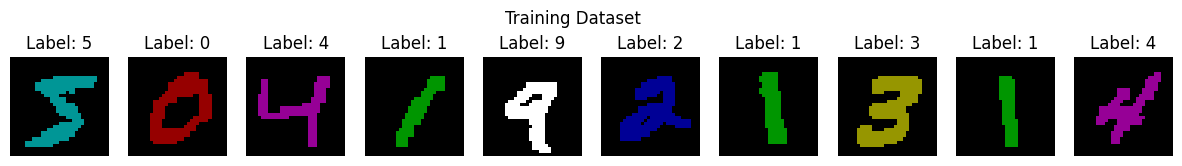

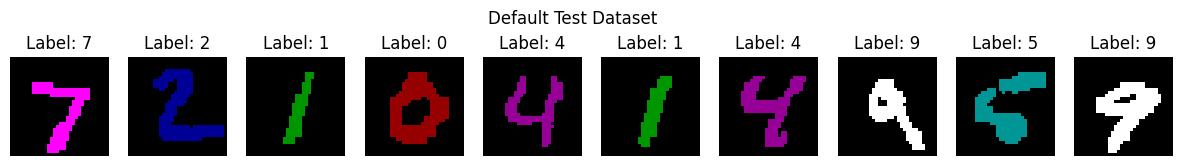

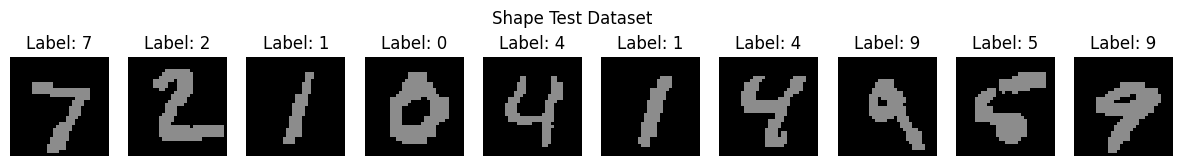

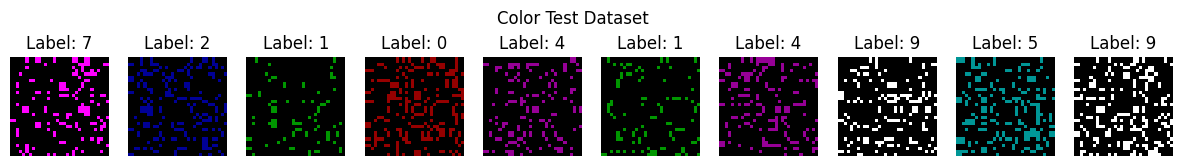

In [1]:
import numpy as np
from PIL import Image
import random
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from dataset import *


train_data = ColoredMNIST(train=True)
test_data_default = ColoredMNIST(train=False)
test_data_shape = ColoredMNIST(train=False, test_mode='shape')
test_data_color = ColoredMNIST(train=False, test_mode='color')

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loaders = {
    'default' :  DataLoader(test_data_default, batch_size=batch_size, shuffle=False),
    'shape' :  DataLoader(test_data_shape, batch_size=batch_size, shuffle=False),
    'color' :  DataLoader(test_data_color, batch_size=batch_size, shuffle=False),
}


visualize_dataset(train_data, title="Training Dataset")
visualize_dataset(test_data_default, title="Default Test Dataset")
visualize_dataset(test_data_shape, title="Shape Test Dataset")
visualize_dataset(test_data_color, title="Color Test Dataset")


In [ ]:
from pytorch_optimizer import SOAP
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn.functional import cross_entropy
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import ViTMAEConfig, ViTMAEForPreTraining
import torch.nn as nn

torch.manual_seed(0)

mae_config = ViTMAEConfig(image_size=32, hidden_size=768, output_hidden_states=True)
mae = ViTMAEForPreTraining(mae_config).cuda()
optimizer = SOAP(mae.parameters(), weight_decay=0)

epochs = 10
scheduler = ExponentialLR(optimizer, 0.1 ** (1 / epochs))
running_loss = torch.zeros(epochs, device='cuda')

for epoch in tqdm(range(epochs)):
    for images, _ in train_loader:
        mae.zero_grad()
        loss = mae(images.cuda()).loss
        running_loss[epoch] += loss.detach()
        loss.backward()
        optimizer.step()
    scheduler.step()

class FineTune(nn.Module):
    def __init__(self, mae_model, num_classes):
        super().__init__()
        self.mae = mae_model
        self.classifier = nn.Linear(self.mae.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.mae(x, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1].mean(dim=1)
        logits = self.classifier(hidden_states)
        return logits


fine = FineTune(mae, 10).cuda()
optimizer_probe = SOAP(fine.parameters(), weight_decay=0)
epochs = 10
scheduler_probe = ExponentialLR(optimizer_probe, 0.1 ** (1 / epochs))
running_probe_loss = torch.zeros(epochs, device='cuda')
running_probe_accuracy = torch.zeros(epochs, device='cuda')
test_accuracies = {key: torch.zeros(epochs, device='cuda') for key in test_loaders}

train_metrics = {
    'loss' : torch.zeros(epochs, device='cuda'),
    'accuracy' : torch.zeros(epochs, device='cuda')
}

for epoch in tqdm(range(epochs)):
    fine.train()
    for images, labels in train_loader:
        optimizer_probe.zero_grad()
        logits = fine(images.cuda())
        labels = labels.cuda()
        loss = cross_entropy(logits, labels)
        train_metrics['loss'][epoch] += loss.detach()
        running_probe_accuracy[epoch] += (
            (logits.argmax(1) == labels).sum().item() / len(train_loader.dataset)
        )
        loss.backward()
        optimizer_probe.step()
    scheduler_probe.step()

    fine.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for images, labels in train_loader:
            logits = fine(test_images.cuda())
            total_correct += (logits.argmax(1) == labels.cuda()).sum().item()
            total_samples += labels.size(0)
        train_metrics['accuracy'] = total_correct / total_samples

        for key, loader in test_loaders.items():
            total_correct = 0
            total_samples = 0
            for test_images, test_labels in loader:
                test_logits = fine(test_images.cuda())
                total_correct += (test_logits.argmax(1) == test_labels.cuda()).sum().item()
                total_samples += test_labels.size(0)
            test_accuracies[key][epoch] = total_correct / total_samples


train_metrics = {
    'loss' : train_metrics['loss'].cpu().numpy() / len(train_loader),
    'accuracy' : train_metrics['accuracy'].cpu().numpy() * 100
}
test_accuracies_np = {key: acc.cpu().numpy() * 100 for key, acc in test_accuracies.items()}


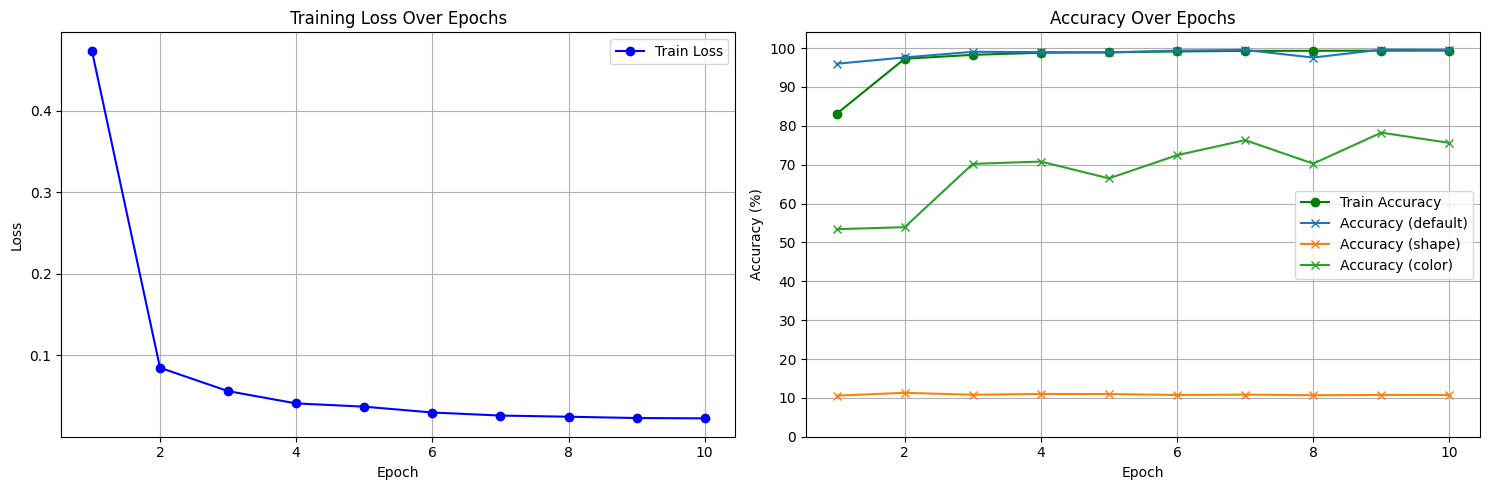

In [4]:
visualize_metrics(train_metrics, test_accuracies_np, epochs=10)